In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.gp import GaussianPrior
from gpzoo.likelihoods import PNMF
from gpzoo.utilities import train_hybrid, train_hybrid_batched, anndata_to_train_val
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import pickle

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [3]:
new_model=False

In [4]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()

In [5]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")

In [6]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<Axes: >

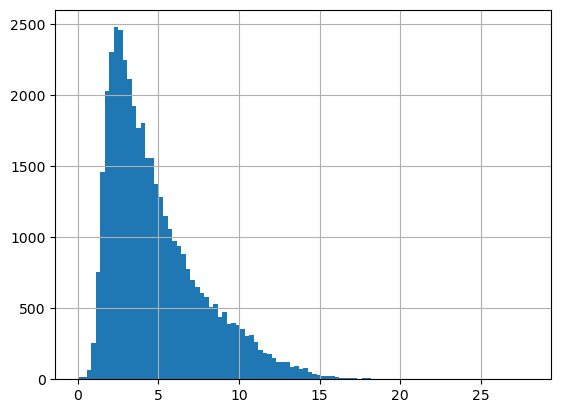

In [7]:
adata.obs.pct_counts_mt.hist(bins=100)

In [8]:
adata = adata[adata.obs.pct_counts_mt < 20] #from 53K to 45K

In [9]:
sc.pp.filter_cells(adata, min_counts=100)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


In [10]:
sc.pp.filter_genes(adata, min_cells=1)

In [11]:
idx = list(range(adata.shape[0]))
random.shuffle(idx)
adata = adata[idx]

In [12]:
Dtr, Dval = anndata_to_train_val(adata, sz="scanpy")

In [13]:
# Y_sums = np.array(np.sum(adata.X > 0, axis=0))[0]

# Y_nsf = np.array(adata.X[:, Y_sums>100].todense() * 100, dtype=int).T
# Y = np.array(adata.X[:].todense()*100, dtype=int).T

In [14]:
Y = Dtr['Y'].T

In [15]:
X = Dtr['X']*50.0

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:26: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


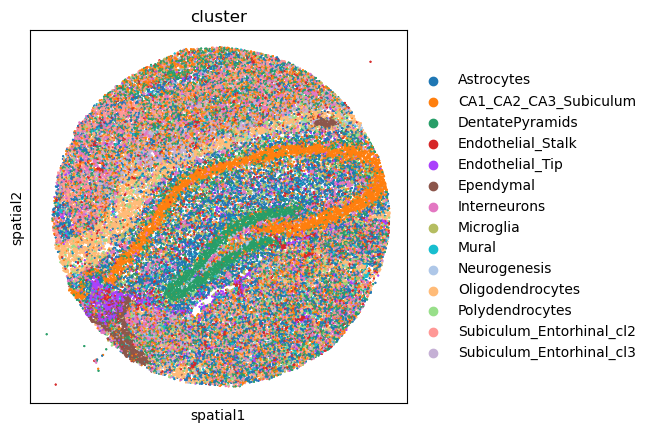

In [16]:
sq.pl.spatial_scatter(adata, color="cluster", size=1, shape=None)

# plt.figure(figsize=(10, 10))
# for i, category in enumerate(adata.obs.cluster.values.categories):
#     mask = adata.obs.cluster.values==category
#     plt.subplot(4, 4, i+1)
#     plt.title(category, fontsize=8)
#     plt.scatter(adata.obs.x[mask], adata.obs.y[mask], alpha=0.1, s=2)
#     plt.xlim([0, 6000])
#     plt.ylim([0, 6000])
#     plt.gca().invert_yaxis()
#     plt.xticks([])
#     plt.yticks([])

In [17]:
# factors, loadings = regularized_nmf(Y.T, L=20, shrinkage=0.3, max_iter = 40, solver='mu', init='nndsvdar', beta_loss='kullback-leibler', random_state=12)

In [18]:
# moran_idx, moranI = dims_autocorr(np.exp(factors), X)

In [19]:
# factors_ordered = factors[:, moran_idx]
# loadings_ordered = loadings[:, moran_idx]

In [20]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

In [21]:
L = 20
prior = GaussianPrior(Y, L=L)
model = PNMF(prior, Y, L=L)
model.to(device)



model.load_state_dict(torch.load('slideseq_pnmf.pth'))
with open("slideseq_pnmf_means.pth", "rb") as fp:   
    means = pickle.load(fp)

with open("slideseq_pnmf_scales.pth", "rb") as fp:   
    scales = pickle.load(fp)

PNMF(
  (prior): GaussianPrior()
)

In [22]:
def train(model, optimizer, y, device, steps=200, E=20, **kwargs):
    losses = []
    
    means = []
    scales = []
    
    for it in tqdm(range(steps)):
        
        optimizer.zero_grad()
        pY, qF, pF = model.forward(E=E, **kwargs)

        logpY = y*torch.log(pY.rate) - pY.rate

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qF, pF))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        #keep W and W2 positive after updates
        
        #model.W.data = torch.clamp(model.W.data, min=0.0)

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales

In [23]:
# X_train = X.to(device)
Y_train = Y.to(device)

In [24]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-1)

In [25]:
# model.gp.jitter=5e-2

In [26]:
model.to(device)
losses, means, scales = train(model, optimizer, Y_train, device, steps=10000, E=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

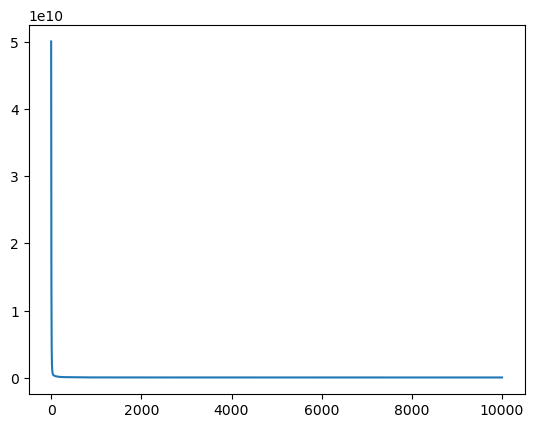

In [27]:
plt.plot(losses)

In [28]:
model.cpu()

qF, pF= model.prior()

factors = torch.exp(qF.mean).detach().cpu().numpy()
factors_scales = torch.nn.functional.softplus(qF.scale.detach().cpu()).numpy()


del qF, pF
# with torch.no_grad():
#     if device.type=='cuda':
#         torch.cuda.empty_cache()

In [29]:
moran_idx, moranI = dims_autocorr(factors.T, X)

In [100]:
def plot(factors, moran_idx, ax=None, size=7, alpha=0.8, names=None):
    
    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)

    if ax is None:
        fig, ax = plt.subplots(4, 5, figsize=(size*5, size*4), tight_layout=True)
        
    for i in range(L):
        plt.subplot(L//5, 5, i+1)
        
        curr_ax = ax[i//5, i%5]
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[moran_idx][i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=0.1)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[moran_idx][i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

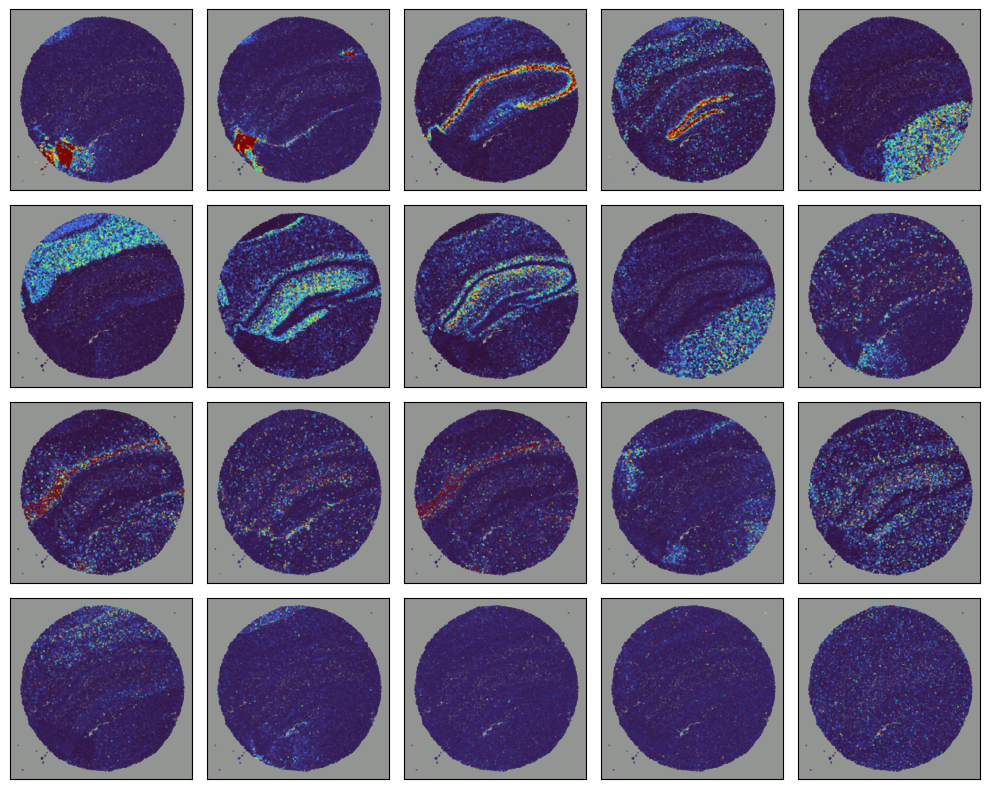

In [101]:
plot(factors, moran_idx, size=2, alpha=0.8)

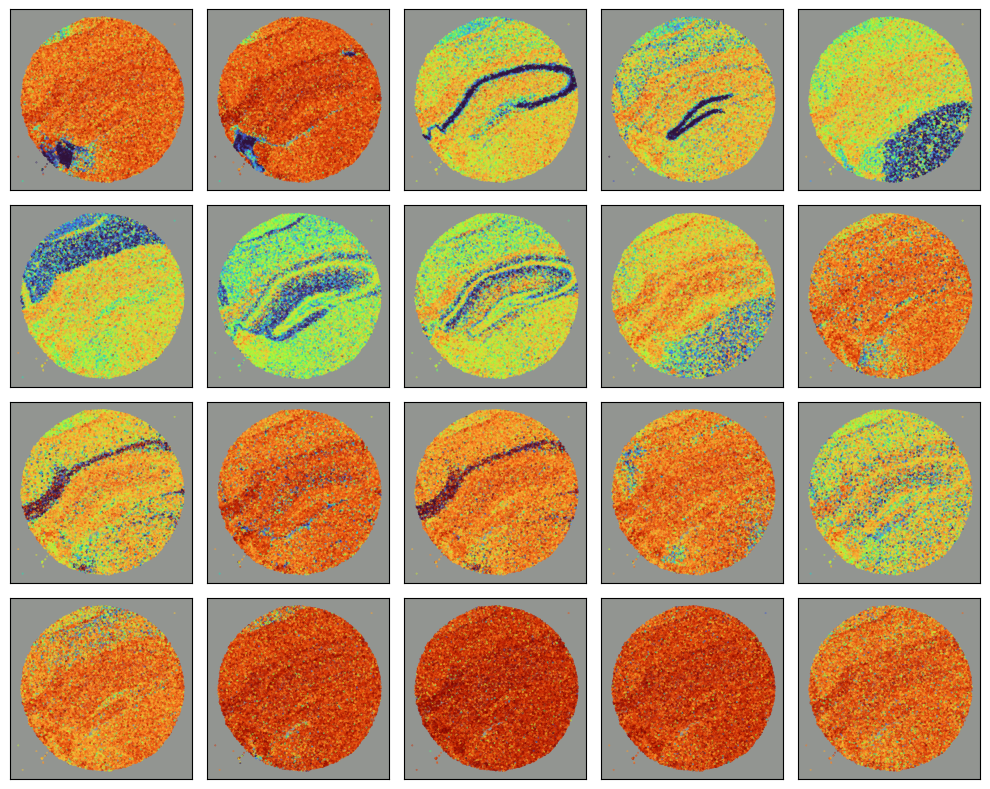

In [102]:
plot(factors_scales, moran_idx, size=2, alpha=0.8)

In [132]:
mask_mt= adata.var_names.str.startswith("mt-")

In [138]:
W = torch.nn.functional.softplus(model.W.detach().cpu()).numpy()
W = W[~mask_mt]
topgenes = W.argmax(axis=0).tolist()
topgenes_names = (adata.var[~mask_mt]).index[topgenes]
topgenes_names

Index(['Ckb', 'Ttr', 'Sparcl1', 'Cst3', 'Meg3', 'Plp1', 'Snap25', 'Malat1',
       'Malat1', 'Meg3', 'Cst3', 'Aldoa', 'Camk2n1', 'Hpca', 'Fth1', 'Plp1',
       'Pcp4', 'Malat1', 'Cmss1', 'Atp1b1'],
      dtype='object')

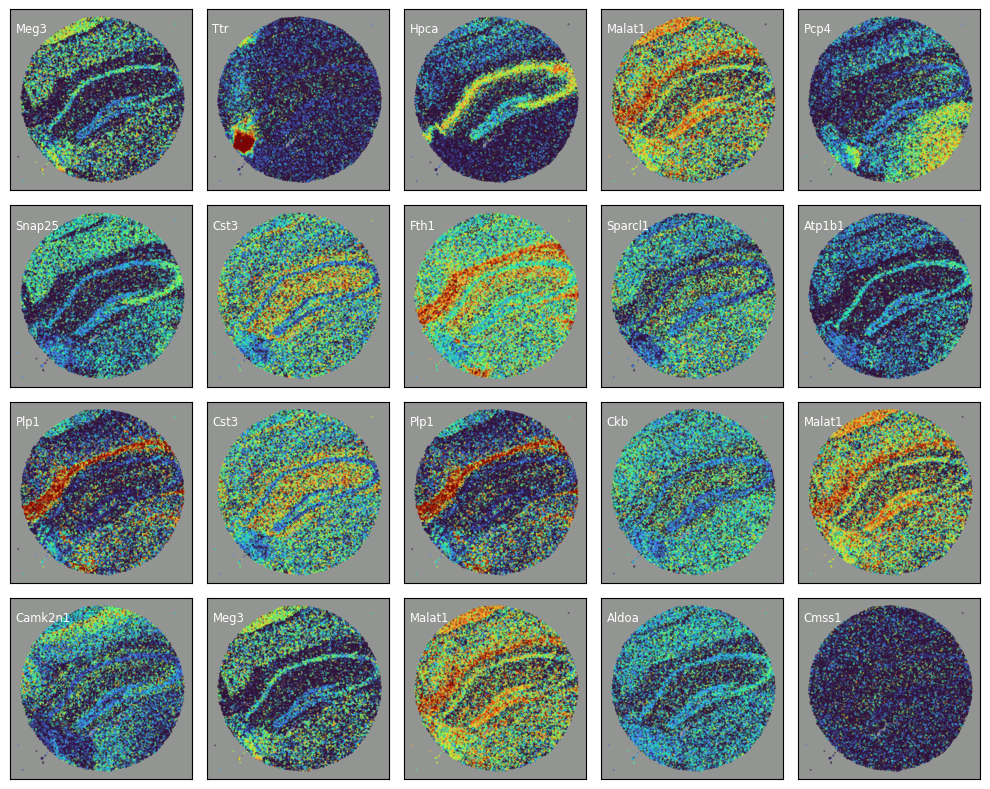

In [142]:
plot((Y[~mask_mt])[topgenes], moran_idx, size=2, alpha=0.8, names=topgenes_names)

hi 0
hi 0
hi 10
hi 20
hi 30
hi 40
hi 50
hi 60
hi 70
hi 80
hi 90
hi 100
hi 110
hi 120
hi 130
hi 140
hi 150
hi 160
hi 170
hi 180
hi 190
hi 200
hi 210
hi 220
hi 230
hi 240
hi 250
hi 260
hi 270
hi 280
hi 290
hi 300
hi 310
hi 320
hi 330
hi 340
hi 350
hi 360
hi 370
hi 380
hi 390
hi 400
hi 410
hi 420
hi 430
hi 440
hi 450
hi 460
hi 470
hi 480
hi 490
hi 500
hi 510
hi 520
hi 530
hi 540
hi 550
hi 560
hi 570
hi 580
hi 590
hi 600
hi 610
hi 620
hi 630
hi 640
hi 650
hi 660
hi 670
hi 680
hi 690
hi 700
hi 710
hi 720
hi 730
hi 740
hi 750
hi 760
hi 770
hi 780
hi 790
hi 800
hi 810
hi 820
hi 830
hi 840
hi 850
hi 860
hi 870
hi 880
hi 890
hi 900
hi 910
hi 920
hi 930
hi 940
hi 950
hi 960
hi 970
hi 980
hi 990


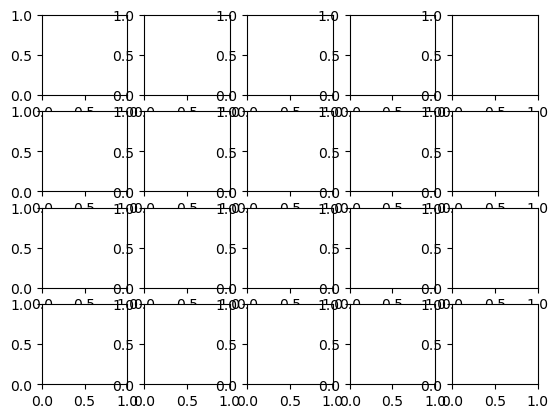

In [127]:
size=2
fig, ax = plt.subplots(4, 5, figsize=(size*5, size*4), tight_layout=True)


def update(iteration):
    for ax_row in ax:
        for element in ax_row:
            element.cla()
    curr_mean = means[iteration]
    
    
    plot(curr_mean, moran_idx, ax=ax, size=size, alpha=0.8)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, 1000, 10), interval=100)
plt.close()
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("pnmf_means.mp4", fps=10, dpi=100)

In [ ]:
size=2
fig, ax = plt.subplots(4, 5, figsize=(size*5, size*4), tight_layout=True)


def update(iteration):
    for ax_row in ax:
        for element in ax_row:
            element.cla()
    curr_scale = scales[iteration]
    
    
    plot(curr_scale, moran_idx, ax=ax, size=size, alpha=0.8)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, 1000, 10), interval=100)
plt.close()
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("pnmf_scales.mp4", fps=10, dpi=100)

hi 0
hi 0


In [61]:
# torch.save(model.state_dict(), 'slideseq_pnmf.pth')
# with open("slideseq_pnmf_means.pth", "wb") as fp:   
#     pickle.dump(means, fp)

# with open("slideseq_pnmf_scales.pth", "wb") as fp:   
#     pickle.dump(scales, fp)

In [145]:
adata.var

MT  n_cells_by_counts  mean_counts  log1p_mean_counts  \
0610005C13Rik  False                 12     0.000147           0.000147   
0610007P14Rik  False               1433     0.012855           0.012773   
0610009B22Rik  False                858     0.008129           0.008096   
0610009E02Rik  False                 70     0.000603           0.000603   
0610009L18Rik  False                332     0.003305           0.003300   
...              ...                ...          ...                ...   
mt-Tr           True                 37     0.000403           0.000403   
mt-Ts2          True                353     0.004786           0.004774   
mt-Tt           True                 41     0.000482           0.000482   
mt-Tv           True                808     0.011218           0.011156   
n-R5-8s1       False                 42     0.000462           0.000462   

               pct_dropout_by_counts  total_counts  log1p_total_counts  \
0610005C13Rik              99.971282      6.122400            1.963245   
0610007P14Rik              96.570622    537.144897            6.288128   
0610009B22Rik              97.946681    339.679626            5.830943   
0610009E02Rik              99.832480     25.190094            3.265381   
0610009L18Rik              99.205476    138.120468            4.935340   
...                              ...           ...                 ...   
mt-Tr                      99.911454     16.853939            2.882224   
mt-Ts2                     99.155219    199.981674            5.303214   
mt-Tt                      99.901881     20.144354            3.051373   
mt-Tv                      98.066338    468.768890            6.152241   
n-R5-8s1                   99.899488     19.315247            3.011372   

               n_cells  highly_variable  highly_variable_rank     means  \
0610005C13Rik       12            False                   NaN  0.000287   
0610007P14Rik     1433            False                   NaN  0.037166   
0610009B22Rik      858            False                   NaN  0.021490   
0610009E02Rik       70            False                   NaN  0.001747   
0610009L18Rik      332            False                   NaN  0.008400   
...                ...              ...                   ...       ...   
mt-Tr               37            False                   NaN  0.000885   
mt-Ts2             353            False                   NaN  0.008520   
mt-Tt               41            False                   NaN  0.000981   
mt-Tv              808            False                   NaN  0.019887   
n-R5-8s1            42            False                   NaN  0.001005   

               variances  variances_norm     mt  
0610005C13Rik   0.000287        0.953021  False  
0610007P14Rik   0.042343        0.926636  False  
0610009B22Rik   0.022944        0.908252  False  
0610009E02Rik   0.001888        0.969810  False  
0610009L18Rik   0.009239        0.956335  False  
...                  ...             ...    ...  
mt-Tr           0.000885        0.913631   True  
mt-Ts2          0.008591        0.876520   True  
mt-Tt           0.000980        0.910922   True  
mt-Tv           0.020641        0.883808   True  
n-R5-8s1        0.001004        0.910268  False  

[17733 rows x 14 columns]